In [19]:
from keras.preprocessing import image
# Transfer Learning Models
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101, ResNet152

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet 
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator

# Layers
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K

import pandas as pd
# Other
from keras import optimizers
from keras import losses
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,MaxPool2D , GlobalAveragePooling2D , AveragePooling2D , BatchNormalization

# Utils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score , matthews_corrcoef , classification_report , roc_auc_score , accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import random, glob
import os, sys, csv
import cv2
import time, datetime
from sklearn.neighbors import KNeighborsClassifier

In [3]:
directory_1 = r"C:\Users\Abinaya Ravichandran\Desktop\Fall 2020\ECE613\Research Project\Detecting_Covid19_CT_Scan\COVID"
directory_2 = r"C:\Users\Abinaya Ravichandran\Desktop\Fall 2020\ECE613\Research Project\Detecting_Covid19_CT_Scan\NORMAL"

x_ = list()
y = list()
IMG_SIZE = 224
c = 0
nc = 0

"COVID Dataset"
for filename in os.listdir(directory_1):
    if filename.endswith(".png") or filename.endswith(".jpg"):
#       print(os.path.join(directory, filename))
        try:
            path = os.path.join(directory_1, filename)
            img = cv2.imread(path)
            img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            img_arr = np.asarray(img_)
            x_.append(img_arr)
            label = 0
            c = c+1
        except:
            None

"NORMAL Dataset"
for filename in os.listdir(directory_2):
    if filename.endswith(".png") or filename.endswith(".jpg"):
#       print(os.path.join(directory, filename))
        try:
            path = os.path.join(directory_2, filename)
            img = cv2.imread(path)
            img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            img_arr = np.asarray(img_)
            x_.append(img_arr)
            label = 1
            nc = nc+1
        except:
            None

In [6]:
x1=[]
from keras.preprocessing import image
for item in x_:
      if len(item.shape) > 2 and item.shape[2] == 4:
            item = cv2.cvtColor(item, cv2.COLOR_BGRA2BGR)
      x1.append(item)
Y = []
for i in range(350):
    Y.append(1)

for i in range(350):
    Y.append(0)
X = np.asarray(x1)
y = np.asarray(Y)
print(X.shape)

(700, 224, 224, 3)


In [7]:
X_train, x_test, y_train, y_test = train_test_split(X , y , test_size=0.10 , random_state=42)
X_train, x_val, y_train, y_val = train_test_split(X_train , y_train, test_size=0.10 , random_state=42)

### **Function for Performance Analysis**

In [23]:
def print_performance_metrics(y_test, max_y_pred_test):
    print('Test Accuracy:', np.round(metrics.accuracy_score(y_test, max_y_pred_test),4))
    print('Precision:', np.round(metrics.precision_score(y_test, max_y_pred_test,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, max_y_pred_test , average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, max_y_pred_test, average='weighted'),4))
    print('ROC AUC:',roc_auc_score(y_test,max_y_pred_test))
    print(classification_report(y_test,max_y_pred_test))

def print_confusion_matrix(y, y_pred):
    
    matrix = confusion_matrix(y_pred, y)
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(matrix,cmap='Blues',linecolor='white',linewidths=1,annot=True,fmt='d')
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


### **VGG-19 Model**

In [11]:
baseModel = VGG19(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model_feat = Model(inputs=baseModel.input, outputs=predictions)

#### KNN Classifier

In [12]:
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model = KNeighborsClassifier(n_neighbors = 5 , metric = 'minkowski' , p=2)
model.fit(feat_train , y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Accuracy (Train): 0.7108
Accuracy (Val): 0.4444


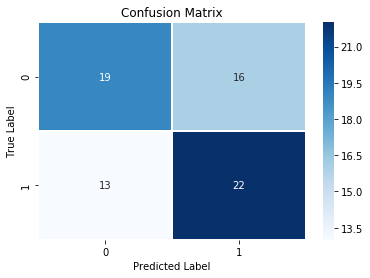

Test Accuracy: 0.5857
Precision: 0.5894
Recall: 0.5857
F1 Score: 0.5865
ROC AUC: 0.5863486842105263
              precision    recall  f1-score   support

           0       0.54      0.59      0.57        32
           1       0.63      0.58      0.60        38

    accuracy                           0.59        70
   macro avg       0.59      0.59      0.58        70
weighted avg       0.59      0.59      0.59        70



In [24]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)

print('Accuracy (Train):' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Accuracy (Val):', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)

### **ANN Classifier**

In [25]:
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model = Sequential()
model.add(Dense(5 , activation = 'relu'))
model.add(Dense(5 , activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics =['accuracy'])
model.fit(feat_train , y_train)

Epoch 1/1
567/567 [==============================] - 0s 186us/step - loss: 0.7140 - accuracy: 0.4832


Training Accuracy : 0.4797
Validation Accuracy : 0.5873


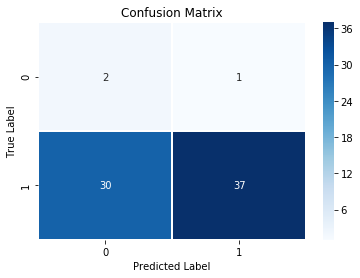

Test Accuracy: 0.5571
Precision: 0.6045
Recall: 0.5571
F1 Score: 0.4348
ROC AUC: 0.518092105263158
              precision    recall  f1-score   support

           0       0.67      0.06      0.11        32
           1       0.55      0.97      0.70        38

    accuracy                           0.56        70
   macro avg       0.61      0.52      0.41        70
weighted avg       0.60      0.56      0.43        70



In [26]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)

print('Training Accuracy :' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Validation Accuracy :', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)

### **Decision Tree Classifier**

In [27]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model.fit(feat_train , y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Training Accuracy : 0.9947
Validation Accuracy : 0.4762


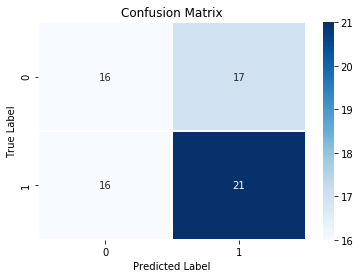

Test Accuracy: 0.5286
Precision: 0.5298
Recall: 0.5286
F1 Score: 0.5291
ROC AUC: 0.5263157894736843
              precision    recall  f1-score   support

           0       0.48      0.50      0.49        32
           1       0.57      0.55      0.56        38

    accuracy                           0.53        70
   macro avg       0.53      0.53      0.53        70
weighted avg       0.53      0.53      0.53        70



In [28]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)

print('Training Accuracy :' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Validation Accuracy :', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)

### **SVM Classiier**

In [29]:
from sklearn.svm import SVC
model = SVC( kernel = 'sigmoid',random_state = 0)

feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model.fit(feat_train , y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

Training Accuracy : 0.5256
Validation Accuracy : 0.4127


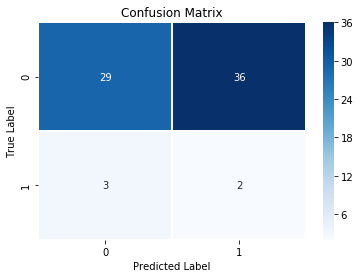

Test Accuracy: 0.4429
Precision: 0.4211
Recall: 0.4429
F1 Score: 0.3238
ROC AUC: 0.4794407894736842
              precision    recall  f1-score   support

           0       0.45      0.91      0.60        32
           1       0.40      0.05      0.09        38

    accuracy                           0.44        70
   macro avg       0.42      0.48      0.35        70
weighted avg       0.42      0.44      0.32        70



In [30]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)

print('Training Accuracy :' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Validation Accuracy :', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)

### **Random Forest Classifier**

In [31]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model.fit(feat_train , y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Training Accuracy : 0.9453
Validation Accuracy : 0.5079


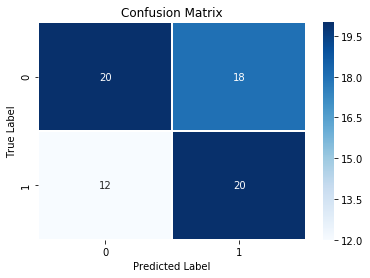

Test Accuracy: 0.5714
Precision: 0.5799
Recall: 0.5714
F1 Score: 0.5714
ROC AUC: 0.575657894736842
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        32
           1       0.62      0.53      0.57        38

    accuracy                           0.57        70
   macro avg       0.58      0.58      0.57        70
weighted avg       0.58      0.57      0.57        70



In [32]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)

print('Training Accuracy :' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Validation Accuracy :', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)

### **AdaBoost Classifier**

In [34]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(x_test)
feat_val = model_feat.predict(x_val)
model.fit(feat_train , y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Training Accuracy : 0.6914
Validation Accuracy : 0.619


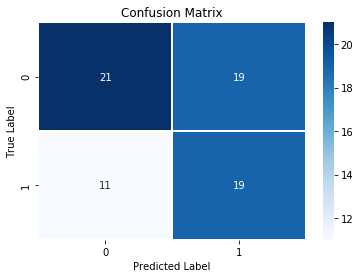

Test Accuracy: 0.5714
Precision: 0.5838
Recall: 0.5714
F1 Score: 0.57
ROC AUC: 0.578125
              precision    recall  f1-score   support

           0       0.53      0.66      0.58        32
           1       0.63      0.50      0.56        38

    accuracy                           0.57        70
   macro avg       0.58      0.58      0.57        70
weighted avg       0.58      0.57      0.57        70



In [35]:
y_pred_train = model.predict(feat_train)
y_pred_test = model.predict(feat_test)
y_pred_val = model.predict(feat_val)
max_y_pred_train = np.round(y_pred_train)
max_y_pred_test = np.round(y_pred_test)
max_y_pred_val = np.round(y_pred_val)
print('Training Accuracy :' , np.round(metrics.accuracy_score(y_train, max_y_pred_train),4))
print('Validation Accuracy :', np.round(metrics.accuracy_score(y_val, max_y_pred_val),4) )
print_confusion_matrix(y_test,max_y_pred_test)
print_performance_metrics(y_test,max_y_pred_test)